# The Anatomy of a mewithoutYou Setlist
Exploring mewithoutYou's 2018-2019 [Untitled] Tour

## Standard Analysis Setup

In [17]:
# Standard imports to run concert_analytics

import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname(""), "../../"))
sys.path.insert(0, PROJECT_ROOT)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import theme, element_text, element_blank, element_rect, element_line

from postgres import fetch_table,run_query

import logging

logging.basicConfig(level=logging.INFO)  # DEBUG < INFO < WARNING < ERROR < CRITICAL

pd.set_option("display.max_columns", None)  # Show all columns

# Step 2: Define the color scale
album_colors = {
    "A To B Life": "#FB9E50",
    "Brother, Sister": "#F986BA",
    "Catch For Us The Foxes": "#3C7DC4",
    "It's All Crazy! It's All False! It's All A Dream! It's Alright": "#D64848",
    "Pale Horses": "#F25C05",
    "Pale Horses: Appendix":"#A7ECF5",
    "Ten Stories": "#5D4E8C",
    "[Untitled]": "#33C27D",
    "[untitled] e.p.": "#F6D357"
}

## Fetch our dataset

In [56]:
# fetch setlist and spotify metadata

query="""
with track_link_cte as (
	select 
 		sim.event_set_song_id
 		,sim.track_id
 		,row_number() over (partition by sim.event_set_song_id order by similarity_score desc nulls last) as similarity_rank_post_filter
	 from 
	 	analytics_mart.mart_track_setlist_similarity_scores as sim 
	 	join analytics_mart.mart_all_tracks as all_tr
	 		on sim.track_id = all_tr.track_id
	 where true
	 	and all_tr.album_id not in ('4bGIhBIGsziCakPziupVmQ','39P5R1B5XF1dGhpojrukVA','06y12naBReESEe7u2OFG7j')
)
, track_link_filtered_cte as (
	select 
 		*
	 from 
	 	track_link_cte
	 where true
	 	and similarity_rank_post_filter = 1
)
select 
	msh.*
	,tr.*
from 
	analytics_mart.mart_setlist_history as msh
	left join track_link_filtered_cte as tl_cte
		on msh.event_set_song_id = tl_cte.event_set_song_id
	left join analytics_mart.mart_all_tracks as tr
		on tl_cte.track_id = tr.track_id
where true
    and msh.event_tour_id = 'dff91b2e201d2bfdb4f7a16b57c62194'
    and msh.event_date <= '2019-01-01'
"""

df = run_query(query)
df.to_csv('mewithoutYou_Untitled_Tour_Data.csv')

## Preview Color Scheme

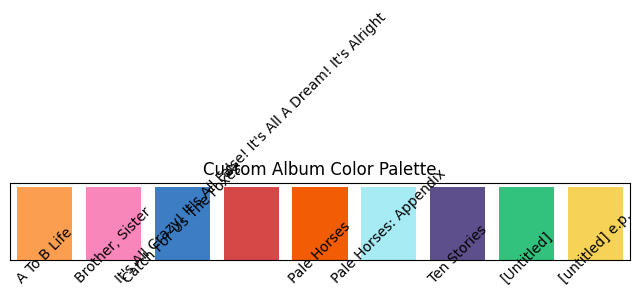

In [15]:
def preview_palette(color_dict):
    fig, ax = plt.subplots(figsize=(8, 1))
    for i, (label, color) in enumerate(color_dict.items()):
        ax.bar(i, 1, color=color)
        ax.text(i, -0.3, label, ha='center', fontsize=10, rotation=45)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-0.5, len(color_dict)-0.5)
    ax.set_title("Custom Album Color Palette")
    plt.show()

preview_palette(album_colors)

## How many songs per night?

In [ ]:
# songs_per_night = 
songs_per_night = (
    df.groupby('event_date')['event_set_song_id']
    .nunique()
    .reset_index(name='unique_song_count')
    .sort_values('event_date')
)

total_shows = songs_per_night['event_date'].nunique()

average_songs = int(songs_per_night['unique_song_count'].mean())

print(f'{total_shows} shows with {average_songs} songs')


from plotnine import ggplot, aes, geom_col, labs, theme, element_text, element_rect, scale_x_datetime
from mizani.breaks import date_breaks
from mizani.formatters import date_format

base_family_axis="Courier New"
base_family_title="Helvetica"

# Build the plot
g = (
    ggplot(songs_per_night, aes(x='event_date', y='unique_song_count')) +
    geom_col(fill='#33C27D') +
    scale_x_datetime(date_labels="%b %d", breaks=date_breaks(width="2 week")) +
    labs(
        title=f"mewithoutYou played {total_shows} shows throughout \ntheir tour, playing {average_songs} songs on the average night",
        subtitle="Unique songs played by show in the 2018 [Untitled] tour",
        y="Unique Songs Played",
        caption="Source: setlist.fm sourced via Concert Analytics"
    ) +
    theme(
        # aspect_ratio = 9 / 16
        # , 
        figure_size=(16,9)
        
        # Backgrounds
        , plot_background=element_rect(fill="#FAF3E0", color=None)
        , panel_background=element_rect(fill="#FAF3E0", color=None)
        , panel_border=element_blank()

        #Margins
        ,plot_margin_top= .03
        ,plot_margin_bottom=.025
        ,plot_margin_right= 0.03
        ,plot_margin_left=0.03

        # Titles & subtitles
        ,plot_title=element_blank()
        #     family=base_family_title+'-Bold'
        #     ,size=30
        #     ,linespacing=1.25
        #     ,weight='bold' 
        #     ,color='#1c1c1c'
        #     ,ha='left'
        #     ,margin={'b': 10 } # spacing below title
        # )

        , plot_subtitle=element_blank()
        #     family=base_family_title
        #     ,size=20
        #     ,color='#777777'
        #     ,ha='left'
        #     ,margin={'b': 30}  # spacing below subtitle
        # )
        
        , plot_caption=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,ha='right'
            ,margin={'t': 30}  # spacing above caption
        )

        # Axis
        ,axis_title=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,weight='ultralight'
            # ,margin={'t': 5, 'r': 5}  # tweak based on axis
        )
        
        ,axis_text=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            # ,margin={'l':5, 't':20}
        )

        ,axis_title_x=element_blank()
        
        ,axis_ticks=element_line(
            color="#FAF3E0"
        )
        ,panel_grid_major_y = element_line(
            color="#777777"
            ,linetype="dashed"
            ,size=.5
        )

        ,axis_ticks_minor=element_blank()
        ,panel_grid_major_x =element_blank()
        ,panel_grid_minor=element_blank()

        # # Legend
        # ,legend_title=element_blank()
        # ,legend_background=element_blank()
        # ,legend_key=element_blank()
        # ,legend_margin=margins(t=5, b=5)
        # ,legend_box_margin=margins(t=10)

    
    )
)

# g

# g.save(
#     filename="viz/0001-mewithoutYou-Songs-per-show.svg",
#     format="svg",
#     width=16,      # inches
#     height=9,     # adjust to your chart’s shape
#     dpi=300        # high-quality output
# )

29 shows with 18 songs


## Unique Songs Total by Album

In [ ]:
# unique songs per album

# Count how many unique songs from each album were played
unique_songs_by_album = (
    songs_albums.groupby('album_name')['track_name']
    .nunique()
    .reset_index(name='unique_song_count')
    .sort_values('unique_song_count', ascending=True)
)


# Create a long-form DataFrame where each album is a segment of the bar
stacked_bar_data = unique_songs_by_album.copy()
stacked_bar_data['x'] = ""  # single category for stacking

from pandas.api.types import CategoricalDtype

# Set album_name as a categorical with explicit order
album_order = stacked_bar_data['album_name'].tolist()
album_cat = CategoricalDtype(categories=album_order, ordered=True)
stacked_bar_data['album_name'] = stacked_bar_data['album_name'].astype(album_cat)

# Step 2: Define the color scale
album_colors = {
    "A To B Life": "#A7ECF5",
    "Brother, Sister": "#F986BA",
    "Catch For Us The Foxes": "#3C7DC4",
    "It's All Crazy! It's All False! It's All A Dream! It's Alright": "#D64848",
    "Pale Horses": "#F25C05",
    "Pale Horses: Appendix":"#A7ECF5",
    "Ten Stories": "#5D4E8C",
    "[Untitled]": "#33C27D",
    "[untitled] e.p.": "#F6D357"
}

# stacked_bar_data.head(5)

from plotnine import ggplot, aes, geom_col, coord_flip, scale_fill_manual, labs

stacked_plot = (
    ggplot(stacked_bar_data, aes(x='x', y='unique_song_count', fill='album_name')) +
    geom_col(width=0.5) +  # single stacked bar
    coord_flip() +
    scale_fill_manual(values=album_colors) +
    labs(
        title="Unique Songs Played per Album on the [Untitled] Tour",
        subtitle="Stacked bar showing how many different songs were performed from each album",
        x=None,
        y="Number of Unique Songs",
        caption="Source: setlist.fm sourced via Concert Analytics"
    ) +
    theme(
        # aspect_ratio = 9 / 16
        # , 
        figure_size=(16,9)
        
        # Backgrounds
        , plot_background=element_rect(fill="#FAF3E0", color=None)
        , panel_background=element_rect(fill="#FAF3E0", color=None)
        , panel_border=element_blank()

        #Margins
        ,plot_margin_top= .03
        ,plot_margin_bottom=.025
        ,plot_margin_right= 0.03
        ,plot_margin_left=0.03

        # Titles & subtitles
        ,plot_title=element_blank()

        , plot_subtitle=element_blank()
        
        , plot_caption=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,ha='right'
            ,margin={'t': 30}  # spacing above caption
        )

        # Axis
        ,axis_title=element_blank()
        
        ,axis_text=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            # ,margin={'l':5, 't':20}
        )

        ,axis_title_y=element_blank()
        ,axis_title_x=element_blank()
        
        ,axis_ticks=element_line(
            color="#FAF3E0"
        )
        ,panel_grid_major_x = element_line(
            color="#777777"
            ,linetype="dashed"
            ,size=.5
        )

        ,axis_ticks_minor=element_blank()
        ,panel_grid_major_y =element_blank()
        ,panel_grid_minor=element_blank()

        # Legend
        ,legend_title=element_blank()
        ,legend_background=element_blank()
        ,legend_key=element_blank()
        ,legend_key_width=10
        , legend_position="bottom"
        , legend_margin=1
        , legend_direction="vertical"
        # ,legend_margin=margins(t=5, b=5)
        # ,legend_box_margin=margins(t=10)

    
    )  + 
    guides(fill=guide_legend(ncol=4,reverse=True))  # your custom theme with background/colors/fonts
)

# stacked_plot.save(
#     filename="viz/0001-mewithoutYou-Songs-per-Album-chart.svg",
#     format="svg",
#     width=16,      # inches
#     height=9,     # adjust to your chart’s shape
#     dpi=300        # high-quality output
# )

## How Many Unique Songs were Played in Total?

In [ ]:
# songs_per_night = 
songs_albums = (
    df.groupby(['track_name','album_name'])['event_set_song_id']
    .nunique()
    .reset_index(name="times_played")
    .sort_values('times_played')
    .reset_index(drop=True)
)

songs_albums['track_name'] = songs_albums['track_name'].apply(
    lambda x: x if len(x) <= 25 else x[:22] + "..."
)

from plotnine import ggplot, aes, geom_col, coord_flip, scale_fill_manual, labs, guides,guide_legend
from plotnine import theme, element_text
import pandas as pd

# Step 1: Make sure song order is preserved
songs_albums_sorted = songs_albums.sort_values('times_played', ascending=True).copy()
songs_albums_sorted['track_name'] = pd.Categorical(
    songs_albums_sorted['track_name'],
    categories=songs_albums_sorted['track_name'],
    ordered=True
)

# Step 3: Create the plot
plot = (
    ggplot(songs_albums_sorted, aes(x='track_name', y='times_played', fill='album_name')) +
    geom_col(show_legend=True) +
    coord_flip() +
    scale_fill_manual(values=album_colors) +
    labs(
        title="Song Frequency on the mewithoutYou [Untitled] Tour",
        subtitle="Each bar shows how many nights a song appeared during the tour",
        x="Song",
        y="Number of Times Played",
        fill=None,
        caption="Source: setlist.fm sourced via Concert Analytics"
    ) +
    theme(
        # aspect_ratio = 9 / 16
        # , 
        figure_size=(12,16)
        
        # Backgrounds
        , plot_background=element_rect(fill="#FAF3E0", color=None)
        , panel_background=element_rect(fill="#FAF3E0", color=None)
        , panel_border=element_blank()

        #Margins
        ,plot_margin_top= .03
        ,plot_margin_bottom=.025
        ,plot_margin_right= 0.03
        ,plot_margin_left=0.03

        # Titles & subtitles
        ,plot_title=element_blank()

        , plot_subtitle=element_blank()
        
        , plot_caption=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,ha='right'
            ,margin={'t': 30}  # spacing above caption
        )

        # Axis
        ,axis_title=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,weight='ultralight'
            # ,margin={'t': 5, 'r': 5}  # tweak based on axis
        )
        
        ,axis_text=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            # ,margin={'l':5, 't':20}
        )

        ,axis_title_y=element_blank()
        
        ,axis_ticks=element_line(
            color="#FAF3E0"
        )
        ,panel_grid_major_x = element_line(
            color="#777777"
            ,linetype="dashed"
            ,size=.5
        )

        ,axis_ticks_minor=element_blank()
        ,panel_grid_major_y =element_blank()
        ,panel_grid_minor=element_blank()

        # Legend
        ,legend_title=element_blank()
        ,legend_background=element_blank()
        ,legend_key=element_blank()
        ,legend_key_width=10
        , legend_position="top"
        , legend_margin=1
        , legend_direction="vertical"
        # ,legend_margin=margins(t=5, b=5)
        # ,legend_box_margin=margins(t=10)

    
    )  + 
    guides(fill=guide_legend(ncol=2,reverse=True))
)

# plot


# plot.save(
#     filename="viz/0001-mewithoutYou-song-frequency-chart.svg",
#     format="svg",
#     width=12,      # inches
#     height=16,     # adjust to your chart’s shape
#     dpi=300        # high-quality output
# )

## Most Common Openers

In [57]:
# songs_per_night = 
opener_songs = (
    df[df.song_index == 1].groupby(['track_name','album_name'])['event_set_song_id']
    .nunique()
    .reset_index(name="times_played")
    .sort_values('times_played')
    .reset_index(drop=True)
)


opener_songs['track_name'] = opener_songs['track_name'].apply(
    lambda x: x if len(x) <= 25 else x[:22] + "..."
)

from plotnine import ggplot, aes, geom_col, coord_flip, scale_fill_manual, labs, guides,guide_legend,element_rect,element_blank,ggplot, aes, geom_col, labs, theme, element_text, element_rect, scale_x_datetime
from plotnine import theme, element_text,scale_y_continuous
import pandas as pd

# Step 1: Make sure song order is preserved
opener_songs_sorted = opener_songs.sort_values('times_played', ascending=True).copy()
opener_songs_sorted['track_name'] = pd.Categorical(
    opener_songs_sorted['track_name'],
    categories=opener_songs_sorted['track_name'],
    ordered=True
)

# Step 3: Create the plot
plot = (
    ggplot(opener_songs_sorted, aes(x='track_name', y='times_played', fill='album_name')) +
    geom_col(show_legend=False) +
    coord_flip() +
    scale_fill_manual(values=album_colors) +
    scale_y_continuous(breaks=range(0, 10, 2)) +
    labs(
        title="Song Frequency on the mewithoutYou [Untitled] Tour",
        subtitle="Each bar shows how many nights a song appeared during the tour",
        x="Song",
        y="Number of Times Played",
        fill=None,
        caption="Source: setlist.fm sourced via Concert Analytics"
    ) +
    theme(
        # aspect_ratio = 9 / 16
        # , 
        figure_size=(12,9)
        
        # Backgrounds
        , plot_background=element_rect(fill="#FAF3E0", color=None)
        , panel_background=element_rect(fill="#FAF3E0", color=None)
        , panel_border=element_blank()

        #Margins
        ,plot_margin_top= .03
        ,plot_margin_bottom=.025
        ,plot_margin_right= 0.03
        ,plot_margin_left=0.03

        # Titles & subtitles
        ,plot_title=element_blank()

        , plot_subtitle=element_blank()
        
        , plot_caption=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,ha='right'
            ,margin={'t': 30}  # spacing above caption
        )

        # Axis
        ,axis_title=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,weight='ultralight'
            # ,margin={'t': 5, 'r': 5}  # tweak based on axis
        )
        
        ,axis_text=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            # ,margin={'l':5, 't':20}
        )

        ,axis_title_y=element_blank()
        
        ,axis_ticks=element_line(
            color="#FAF3E0"
        )
        ,panel_grid_major_x = element_line(
            color="#777777"
            ,linetype="dashed"
            ,size=.5
        )

        ,axis_ticks_minor=element_blank()
        ,panel_grid_major_y =element_blank()
        ,panel_grid_minor=element_blank()

        # Legend
        ,legend_title=element_blank()
        ,legend_background=element_blank()
        ,legend_key=element_blank()
        ,legend_key_width=10
        , legend_position="top"
        , legend_margin=1
        , legend_direction="vertical"
        # ,legend_margin=margins(t=5, b=5)
        # ,legend_box_margin=margins(t=10)

    
    )  + 
    guides(fill=guide_legend(ncol=2,reverse=True))
)

# plot


plot.save(
    filename="viz/0002-mewithoutYou-Opener_Frequency.svg",
    format="svg",
    width=12,      # inches
    height=9,     # adjust to your chart’s shape
    dpi=300        # high-quality output
)

/Users/nahumgarcia/Reservoir/ReservoirResearchGroup/concert-analytics/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 9 in image.
/Users/nahumgarcia/Reservoir/ReservoirResearchGroup/concert-analytics/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: viz/0002-mewithoutYou-Opener_Frequency.svg


## Most Common Closer

In [58]:
# songs_per_night = 
closer_songs = (
    df[df.song_index_reversed == 1].groupby(['track_name','album_name'])['event_set_song_id']
    .nunique()
    .reset_index(name="times_played")
    .sort_values('times_played')
    .reset_index(drop=True)
)


closer_songs['track_name'] = closer_songs['track_name'].apply(
    lambda x: x if len(x) <= 25 else x[:22] + "..."
)

from plotnine import ggplot, aes, geom_col, coord_flip, scale_fill_manual, labs, guides,guide_legend,element_rect,element_blank,ggplot, aes, geom_col, labs, theme, element_text, element_rect, scale_x_datetime
from plotnine import theme, element_text,scale_y_continuous
import pandas as pd

# Step 1: Make sure song order is preserved
closer_songs_sorted = closer_songs.sort_values('times_played', ascending=True).copy()
closer_songs_sorted['track_name'] = pd.Categorical(
    closer_songs_sorted['track_name'],
    categories=closer_songs_sorted['track_name'],
    ordered=True
)

# Step 3: Create the plot
plot = (
    ggplot(closer_songs_sorted, aes(x='track_name', y='times_played', fill='album_name')) +
    geom_col(show_legend=False) +
    coord_flip() +
    scale_fill_manual(values=album_colors) +
    scale_y_continuous(breaks=range(0, 16, 2)) +
    labs(
        title="Song Frequency on the mewithoutYou [Untitled] Tour",
        subtitle="Each bar shows how many nights a song appeared during the tour",
        x="Song",
        y="Number of Times Played",
        fill=None,
        caption="Source: setlist.fm sourced via Concert Analytics"
    ) +
    theme(
        # aspect_ratio = 9 / 16
        # , 
        figure_size=(12,9)
        
        # Backgrounds
        , plot_background=element_rect(fill="#FAF3E0", color=None)
        , panel_background=element_rect(fill="#FAF3E0", color=None)
        , panel_border=element_blank()

        #Margins
        ,plot_margin_top= .03
        ,plot_margin_bottom=.025
        ,plot_margin_right= 0.03
        ,plot_margin_left=0.03

        # Titles & subtitles
        ,plot_title=element_blank()

        , plot_subtitle=element_blank()
        
        , plot_caption=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,ha='right'
            ,margin={'t': 30}  # spacing above caption
        )

        # Axis
        ,axis_title=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,weight='ultralight'
            # ,margin={'t': 5, 'r': 5}  # tweak based on axis
        )
        
        ,axis_text=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            # ,margin={'l':5, 't':20}
        )

        ,axis_title_y=element_blank()
        
        ,axis_ticks=element_line(
            color="#FAF3E0"
        )
        ,panel_grid_major_x = element_line(
            color="#777777"
            ,linetype="dashed"
            ,size=.5
        )

        ,axis_ticks_minor=element_blank()
        ,panel_grid_major_y =element_blank()
        ,panel_grid_minor=element_blank()

        # Legend
        ,legend_title=element_blank()
        ,legend_background=element_blank()
        ,legend_key=element_blank()
        ,legend_key_width=10
        , legend_position="top"
        , legend_margin=1
        , legend_direction="vertical"
        # ,legend_margin=margins(t=5, b=5)
        # ,legend_box_margin=margins(t=10)

    
    )  + 
    guides(fill=guide_legend(ncol=2,reverse=True))
)

# plot


plot.save(
    filename="viz/0002-mewithoutYou-Closer_Frequency.svg",
    format="svg",
    width=12,      # inches
    height=9,     # adjust to your chart’s shape
    dpi=300        # high-quality output
)

/Users/nahumgarcia/Reservoir/ReservoirResearchGroup/concert-analytics/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 9 in image.
/Users/nahumgarcia/Reservoir/ReservoirResearchGroup/concert-analytics/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: viz/0002-mewithoutYou-Closer_Frequency.svg


## Most Common Closer of the First Set

In [72]:
# songs_per_night = 
closer_songs = (
    df.query("song_position_in_set_index_reversed == 1 and set_index == 1")
    .groupby(['track_name','album_name'])['event_set_song_id']
    .nunique()
    .reset_index(name="times_played")
    .sort_values('times_played')
    .reset_index(drop=True)
)


closer_songs['track_name'] = closer_songs['track_name'].apply(
    lambda x: x if len(x) <= 25 else x[:22] + "..."
)

from plotnine import ggplot, aes, geom_col, coord_flip, scale_fill_manual, labs, guides,guide_legend,element_rect,element_blank,ggplot, aes, geom_col, labs, theme, element_text, element_rect, scale_x_datetime
from plotnine import theme, element_text,scale_y_continuous
import pandas as pd

# Step 1: Make sure song order is preserved
closer_songs_sorted = closer_songs.sort_values('times_played', ascending=True).copy()
closer_songs_sorted['track_name'] = pd.Categorical(
    closer_songs_sorted['track_name'],
    categories=closer_songs_sorted['track_name'],
    ordered=True
)

# Step 3: Create the plot
plot = (
    ggplot(closer_songs_sorted, aes(x='track_name', y='times_played', fill='album_name')) +
    geom_col(show_legend=False) +
    coord_flip() +
    scale_fill_manual(values=album_colors) +
    scale_y_continuous(breaks=range(0, 18, 2)) +
    labs(
        title="Song Frequency on the mewithoutYou [Untitled] Tour",
        subtitle="Each bar shows how many nights a song appeared during the tour",
        x="Song",
        y="Number of Times Played",
        fill=None,
        caption="Source: setlist.fm sourced via Concert Analytics"
    ) +
    theme(
        # aspect_ratio = 9 / 16
        # , 
        figure_size=(12,9)
        
        # Backgrounds
        , plot_background=element_rect(fill="#FAF3E0", color=None)
        , panel_background=element_rect(fill="#FAF3E0", color=None)
        , panel_border=element_blank()

        #Margins
        ,plot_margin_top= .03
        ,plot_margin_bottom=.025
        ,plot_margin_right= 0.03
        ,plot_margin_left=0.03

        # Titles & subtitles
        ,plot_title=element_blank()

        , plot_subtitle=element_blank()
        
        , plot_caption=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,ha='right'
            ,margin={'t': 30}  # spacing above caption
        )

        # Axis
        ,axis_title=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,weight='ultralight'
            # ,margin={'t': 5, 'r': 5}  # tweak based on axis
        )
        
        ,axis_text=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            # ,margin={'l':5, 't':20}
        )

        ,axis_title_y=element_blank()
        
        ,axis_ticks=element_line(
            color="#FAF3E0"
        )
        ,panel_grid_major_x = element_line(
            color="#777777"
            ,linetype="dashed"
            ,size=.5
        )

        ,axis_ticks_minor=element_blank()
        ,panel_grid_major_y =element_blank()
        ,panel_grid_minor=element_blank()

        # Legend
        ,legend_title=element_blank()
        ,legend_background=element_blank()
        ,legend_key=element_blank()
        ,legend_key_width=10
        , legend_position="top"
        , legend_margin=1
        , legend_direction="vertical"
        # ,legend_margin=margins(t=5, b=5)
        # ,legend_box_margin=margins(t=10)

    
    )  + 
    guides(fill=guide_legend(ncol=2,reverse=True))
)

# plot


plot.save(
    filename="viz/0002-mewithoutYou-First_Set_Closer_Frequency.svg",
    format="svg",
    width=12,      # inches
    height=9,     # adjust to your chart’s shape
    dpi=300        # high-quality output
)


/Users/nahumgarcia/Reservoir/ReservoirResearchGroup/concert-analytics/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 9 in image.
/Users/nahumgarcia/Reservoir/ReservoirResearchGroup/concert-analytics/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: viz/0002-mewithoutYou-First_Set_Closer_Frequency.svg


## Most Common Opener of the last set

In [73]:
# songs_per_night = 
closer_songs = (
    df.query("song_position_in_set_index == 1 and set_index_reversed == 1")
    .groupby(['track_name','album_name'])['event_set_song_id']
    .nunique()
    .reset_index(name="times_played")
    .sort_values('times_played')
    .reset_index(drop=True)
)


closer_songs['track_name'] = closer_songs['track_name'].apply(
    lambda x: x if len(x) <= 25 else x[:22] + "..."
)

from plotnine import ggplot, aes, geom_col, coord_flip, scale_fill_manual, labs, guides,guide_legend,element_rect,element_blank,ggplot, aes, geom_col, labs, theme, element_text, element_rect, scale_x_datetime
from plotnine import theme, element_text,scale_y_continuous
import pandas as pd

# Step 1: Make sure song order is preserved
closer_songs_sorted = closer_songs.sort_values('times_played', ascending=True).copy()
closer_songs_sorted['track_name'] = pd.Categorical(
    closer_songs_sorted['track_name'],
    categories=closer_songs_sorted['track_name'],
    ordered=True
)

# Step 3: Create the plot
plot = (
    ggplot(closer_songs_sorted, aes(x='track_name', y='times_played', fill='album_name')) +
    geom_col(show_legend=False) +
    coord_flip() +
    scale_fill_manual(values=album_colors) +
    scale_y_continuous(breaks=range(0, 18, 2)) +
    labs(
        title="Song Frequency on the mewithoutYou [Untitled] Tour",
        subtitle="Each bar shows how many nights a song appeared during the tour",
        x="Song",
        y="Number of Times Played",
        fill=None,
        caption="Source: setlist.fm sourced via Concert Analytics"
    ) +
    theme(
        # aspect_ratio = 9 / 16
        # , 
        figure_size=(12,9)
        
        # Backgrounds
        , plot_background=element_rect(fill="#FAF3E0", color=None)
        , panel_background=element_rect(fill="#FAF3E0", color=None)
        , panel_border=element_blank()

        #Margins
        ,plot_margin_top= .03
        ,plot_margin_bottom=.025
        ,plot_margin_right= 0.03
        ,plot_margin_left=0.03

        # Titles & subtitles
        ,plot_title=element_blank()

        , plot_subtitle=element_blank()
        
        , plot_caption=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,ha='right'
            ,margin={'t': 30}  # spacing above caption
        )

        # Axis
        ,axis_title=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,weight='ultralight'
            # ,margin={'t': 5, 'r': 5}  # tweak based on axis
        )
        
        ,axis_text=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            # ,margin={'l':5, 't':20}
        )

        ,axis_title_y=element_blank()
        
        ,axis_ticks=element_line(
            color="#FAF3E0"
        )
        ,panel_grid_major_x = element_line(
            color="#777777"
            ,linetype="dashed"
            ,size=.5
        )

        ,axis_ticks_minor=element_blank()
        ,panel_grid_major_y =element_blank()
        ,panel_grid_minor=element_blank()

        # Legend
        ,legend_title=element_blank()
        ,legend_background=element_blank()
        ,legend_key=element_blank()
        ,legend_key_width=10
        , legend_position="top"
        , legend_margin=1
        , legend_direction="vertical"
        # ,legend_margin=margins(t=5, b=5)
        # ,legend_box_margin=margins(t=10)

    
    )  + 
    guides(fill=guide_legend(ncol=2,reverse=True))
)

# plot


plot.save(
    filename="viz/0002-mewithoutYou-Encore_Set_Opener_Frequency.svg",
    format="svg",
    width=12,      # inches
    height=9,     # adjust to your chart’s shape
    dpi=300        # high-quality output
)


/Users/nahumgarcia/Reservoir/ReservoirResearchGroup/concert-analytics/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 9 in image.
/Users/nahumgarcia/Reservoir/ReservoirResearchGroup/concert-analytics/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: viz/0002-mewithoutYou-Encore_Set_Opener_Frequency.svg


## The average [Untitled] Set list 

In [101]:
avg_setlist = (
    df.groupby(['track_name','album_name'])
    .agg(
        min_position=('song_index', 'min')
        ,p25=('song_index', lambda x: x.quantile(0.35))
        ,avg_position=('song_index', 'mean')
        ,median_position=('song_index', 'median')
        ,p75=('song_index', lambda x: x.quantile(0.65))
        ,max_position=('song_index', 'max')
        ,times_played=('song_index', 'count')
    )
    .reset_index()
    .sort_values('median_position', ascending=False)
    .reset_index(drop=True)
)

# Assume you already have median_position in summary
# Now count how many times each song appears at exactly its median
counts_at_median = (
    df.merge(avg_setlist[['track_name', 'median_position']], on='track_name')
    .assign(is_at_median=lambda d: d['song_index'] == d['median_position'])
    .groupby('track_name')['is_at_median']
    .sum()
    .reset_index(name='median_count')
)

# Merge back into summary
avg_setlist = avg_setlist.merge(counts_at_median, on='track_name', how='left')
avg_setlist['median_count'] = avg_setlist['median_count'].fillna(1)

from pandas.api.types import CategoricalDtype

cat_type = CategoricalDtype(categories=avg_setlist['track_name'], ordered=True)
avg_setlist['track_name'] = avg_setlist['track_name'].astype(cat_type)

avg_setlist['track_name'] = avg_setlist['track_name'].apply(
    lambda x: x if len(x) <= 25 else x[:22] + "..."
)

# avg_setlist.head(60)

from plotnine import ggplot, aes, geom_segment, geom_point, theme_minimal, labs, theme, element_text,scale_color_manual,scale_size_continuous

# Build the plot
plot = (
    ggplot(avg_setlist, aes(y='track_name'))
    + geom_point(
        aes(x='min_position', color='album_name'),
        size=1.5
        ,show_legend=False
        ,alpha=0.3
    )
    + geom_point(
        aes(x='max_position', color='album_name'),
        size=1.5
        ,show_legend=False
        ,alpha=0.3
    )
    + geom_segment(
        aes(x='p25', xend='p75', y='track_name', yend='track_name', color='album_name'),
        size=2
        ,show_legend=False
        ,alpha=0.5
    )
    + geom_point(
        aes(
            x='median_position'
            , color='album_name'
            , size='median_count'
            )
        ,show_legend=True
    )
    + scale_size_continuous(range=[1, 5])
    + scale_color_manual(values=album_colors) 
    + labs(
        title='Song Positions Across Setlists',
        subtitle='Each line shows min to max position for a song, dot shows average',
        x='Setlist Position',
        y='Song',
        color='Album'
        ,caption="Source: setlist.fm sourced via Concert Analytics"
    )
    +
    theme(
        # aspect_ratio = 9 / 16
        # , 
        figure_size=(12,19)
        
        # Backgrounds
        , plot_background=element_rect(fill="#FAF3E0", color=None)
        , panel_background=element_rect(fill="#FAF3E0", color=None)
        , panel_border=element_blank()

        #Margins
        ,plot_margin_top= .03
        ,plot_margin_bottom=.025
        ,plot_margin_right= 0.03
        ,plot_margin_left=0.03

        # Titles & subtitles
        ,plot_title=element_blank()

        , plot_subtitle=element_blank()
        
        , plot_caption=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,ha='right'
            ,margin={'t': 30}  # spacing above caption
        )

        # Axis
        ,axis_title=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            ,weight='ultralight'
            # ,margin={'t': 5, 'r': 5}  # tweak based on axis
        )
        
        ,axis_text=element_text(
            family=base_family_axis
            ,size=12
            ,color='#777777'
            # ,margin={'l':5, 't':20}
        )

        ,axis_title_y=element_blank()
        
        ,axis_ticks=element_line(
            color="#FAF3E0"
        )
        ,panel_grid_major_x = element_line(
            color="#777777"
            ,linetype="dashed"
            ,size=.5
        )

        ,axis_ticks_minor=element_blank()
        ,panel_grid_major_y =element_blank()
        ,panel_grid_minor=element_blank()

        # Legend
        ,legend_title=element_blank()
        ,legend_background=element_blank()
        ,legend_key=element_blank()
        ,legend_key_width=10
        , legend_position="top"
        , legend_margin=1
        , legend_direction="vertical"
        # ,legend_margin=margins(t=5, b=5)
        # ,legend_box_margin=margins(t=10)

    
    )  + 
    guides(fill=guide_legend(ncol=2,reverse=True))
)

# plot

plot.save(
    filename="viz/0002-mewithoutYou-Setlist_Position_Spread.svg",
    format="svg",
    width=12,      # inches
    height=19,     # adjust to your chart’s shape
    dpi=300        # high-quality output
)

# avg_setlist.head(60)


/Users/nahumgarcia/Reservoir/ReservoirResearchGroup/concert-analytics/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:615: PlotnineWarning: Saving 12 x 19 in image.
/Users/nahumgarcia/Reservoir/ReservoirResearchGroup/concert-analytics/.venv/lib/python3.13/site-packages/plotnine/ggplot.py:616: PlotnineWarning: Filename: viz/0002-mewithoutYou-Setlist_Position_Spread.svg


In [ ]:
## Rarest Songs

In [ ]:
## Album Representation per Show

In [ ]:
## How popularity moves within a set

In [ ]:
## City that got the worst or best set list

In [ ]:
## How popularity moved for the tour (avg. Popularity per show)